In [1]:
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from tqdm import tqdm
from utils.datasets import ACDCDataset
from sklearn.manifold import TSNE

In [2]:
augmentation = albumentations.Compose([
    albumentations.Resize(520, 520),
    albumentations.CLAHE(p=1.),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=False)
test_dataset = ACDCDataset('../data/acdc/testing/testing', None, augmentation, preload=False, load_mask=False)
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)

In [3]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1328, 574, 1076)

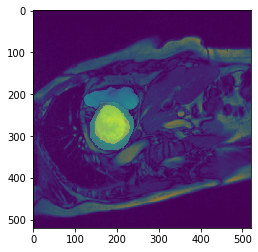

In [4]:
c, img, mask = dataset[70]
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load('/Users/airplaneless/source/projects/medsegmentation/models/fcn-shufflenetV2/fcn-shufflenetV2.pth', map_location=device)

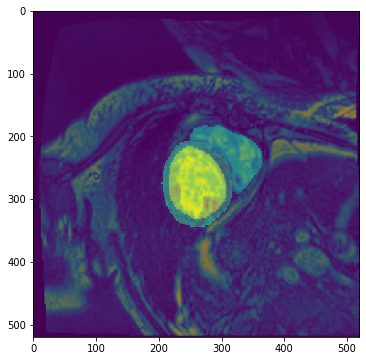

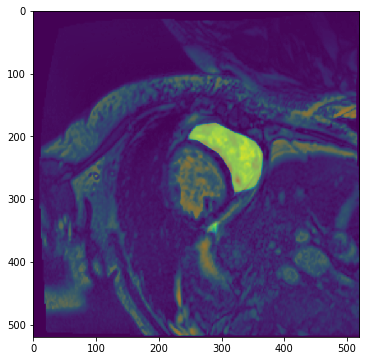

In [6]:
c, img, mask = val_dataset[59]

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))['out'][0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[1], alpha=0.5)
plt.show()

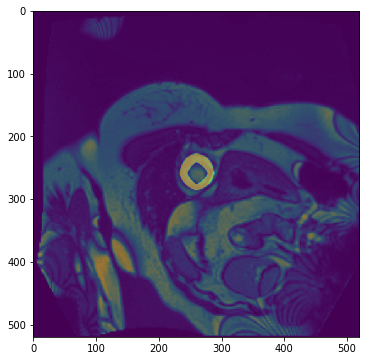

In [7]:
_, img, _ = test_dataset[19]

model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))['out'][0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[2], alpha=0.5)
plt.show()

In [8]:
features = torch.nn.Sequential(model.backbone.conv1, model.backbone.maxpool, 
                               model.backbone.stage2, model.backbone.stage3, model.backbone.stage4, 
                               torch.nn.AdaptiveMaxPool2d((1,1)))

In [9]:
model.eval()
with torch.no_grad():
    pred = features(img.unsqueeze(0).to(device)).flatten()

In [10]:
pred.shape

torch.Size([464])

In [11]:
X = np.zeros((len(dataset) + len(test_dataset), 464))
cats = np.zeros(len(dataset) + len(test_dataset))
splits = np.zeros(len(dataset) + len(test_dataset))

for i, (c, img, _) in tqdm(enumerate(train_dataset), total=len(train_dataset)):
    with torch.no_grad():
        pred = features(img.unsqueeze(0).to(device)).flatten().cpu().numpy()
    X[i] = pred
    splits[i] = 0
    cats[i] = c
    
displ = len(train_dataset)
for i, (c, img, _) in tqdm(enumerate(val_dataset), total=len(val_dataset)):
    i += displ
    with torch.no_grad():
        pred = features(img.unsqueeze(0).to(device)).flatten().cpu().numpy()
    X[i] = pred
    splits[i] = 1
    cats[i] = c

displ = len(dataset)
for i, (_, img, _) in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    i += displ
    with torch.no_grad():
        pred = features(img.unsqueeze(0).to(device)).flatten().cpu().numpy()
    X[i] = pred
    splits[i] = 2
    cats[i] = -1
    

100%|██████████| 1076/1076 [03:45<00:00,  4.77it/s]


KeyError: 1076

In [21]:
for c, _, _ in tqdm(test_dataset):
    c = 42

100%|██████████| 1076/1076 [01:07<00:00, 15.99it/s]


KeyError: 1076

In [23]:
for c, _, _ in tqdm(dataset):
    c = 42

100%|██████████| 1902/1902 [01:03<00:00, 29.88it/s]


KeyError: 1902

In [24]:
X.shape

(2978, 464)

In [12]:
Xr = TSNE(verbose=True).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1902 samples in 0.022s...
[t-SNE] Computed neighbors for 1902 samples in 2.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1902
[t-SNE] Computed conditional probabilities for sample 1902 / 1902
[t-SNE] Mean sigma: 5.870990
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.321945
[t-SNE] KL divergence after 1000 iterations: 1.234617


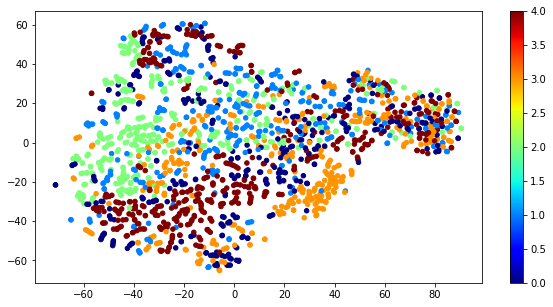

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(x=Xr[:,0], y=Xr[:,1], c=cats, s=20, cmap=plt.cm.jet)
plt.colorbar()
plt.show()